In [109]:
# compare phase vs. percent transition
# compare amplitude vs. percent transition

In [110]:
import sys
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

In [111]:
# obtain percent transition vs. time
def getWeights(filename):
    weights = []
    times = []
    bag = rosbag.Bag(filename)
    for topic, msg, t in bag.read_messages(topics=["/roboy_dep/linear_combination"]):
        weights.append(msg.weights)
        times.append(t.to_sec())
    bag.close()
    return np.array(weights), np.array(times)

In [112]:
# obtain data from file
def getData(filename):
    position_to_rads = 2.0*3.14159/(2000.0*53.0);
    displacement_to_N = 0.237536
    time = []
    pos = []
    force = []
    bag = rosbag.Bag(filename)
    for topic, msg, t in bag.read_messages(topics=["/roboy/middleware/MotorStatus"]):
        pos.append(msg.position)
        force.append(msg.displacement)
        time.append(t.to_sec())
    bag.close()
    time = np.array(time)
    pos = np.array(pos)*position_to_rads
    force = np.array(force)*displacement_to_N
    return time, pos, force

In [113]:
def getPeriods(sequence):
    zeros = []
    for i in range(1,len(sequence)):
        if sequence[i-1] < 0 and sequence[i] > 0:
            zeros.append(i)
    periods = []
    for i in range(1,len(zeros)):
        periods.append((zeros[i-1],zeros[i]))
    return periods

In [114]:
def getMaxima(sequence,periods):
    maxima = []
    for period in periods:
        maxima.append(np.argmax(sequence[period[0]:period[1]])+period[0])
    return np.array(maxima)

In [115]:
def getEndIndex(weights):
    a = weights[1:-1,1]-weights[2:,1]
    for i in range(len(a)):
        if a[i] > 0:
            return i

In [116]:
#specify file, motors of interest, and reference motor
#filename = "/home/roboy/dep_data/data/combination/10FB04FS_04FB10FS_200s_2017-10-18-12-50-31.bag"
filename = "/home/roboy/dep_data/data/combination/10FB04SD_04FB10SD_200s_2017-10-18-12-55-03.bag"
muscle = 1
ref_motor = 5

In [117]:
muscle_to_motor = [0, 1, 3, 12, 10, 5, 4, 0, 0, 0, 0, 0, 0, 0]
motor_to_muscle = [0, 1, 0, 2, 6, 5, 0, 0, 0, 0, 4, 0, 3, 0]
color_pallette = ['#2274A5', '#B4656F', '#4E937A', '#F3D34A', '#A11692', '#F75C03', '#F1C40F', '#D90368', '#00CC66', '#540B0E', '#2274A5', '#B4656F', '#4E937A', '#F3D34A']

In [118]:
motor = muscle_to_motor[muscle]

In [119]:
weights, times = getWeights(filename)

In [120]:
time, pos, force = getData(filename)

In [121]:
offset = 0
while((time[offset]-times[0])<0):
    offset += 1
i_start = offset
i_end = offset + getEndIndex(weights)

In [122]:
ref = pos[:,ref_motor][i_start:i_end]
muscle = pos[:,motor][i_start:i_end]

periods = getPeriods(muscle)

ref_peaks = getMaxima(ref,periods) #indices of maxima
muscle_peaks = getMaxima(muscle,periods) #indices of maxima

In [123]:
avg_dist = np.ma.average((ref_peaks-np.roll(ref_peaks,1))[1:])
#std_dist = np.std((ref_peaks-np.roll(ref_peaks,1))[1:])

In [126]:
y = ((muscle_peaks-ref_peaks))/avg_dist*360
y = -1*y
x = (weights[muscle_peaks-offset][:,1]-0.4)/0.6*100

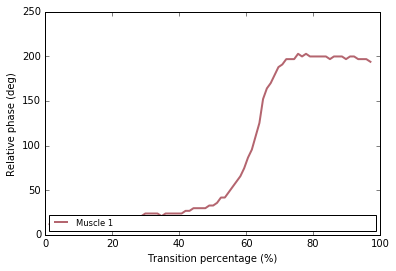

In [127]:
plt.figure(1)
plt.plot(x,y,color=color_pallette[motor],linewidth=2,label="Muscle "+str(motor_to_muscle[motor]))
fontP = FontProperties()
fontP.set_size('small')
plt.figure(1)
plt.ylabel("Relative phase (deg)")
plt.xlabel("Transition percentage (%)")
plt.legend(loc="lower center", mode="expand", ncol=6, prop=fontP)
plt.show()

# Older attempt

In [162]:
# need to remove bit of recording before and after actual experiment
# inspect plot and provide approximate cutoff times
t_start = time[offset]-time[0]+1.0
t_end = time[offset+getEndIndex(weights)]-time[0]-1.0
print(t_start,t_end)

(2.3994739055633545, 200.33953666687012)


In [161]:
# obtain minima of given muscle data
from scipy.signal import argrelextrema
def getPeaks(position):
    indices = np.array(argrelextrema(position, np.less))
    return indices

##### Obtaining muscle and reference peak indices

In [162]:
def movingAvg(data, window_size):
    a = []
    for i in range(len(data)):
        a.append(np.ma.average(data[np.clip(i-window_size,0,len(data)):np.clip(i,0,len(data))]))
    return np.array(a)

In [163]:
# remove indices above/below cutoff times from peaks
def trim(indices,t_start,t_end):
    i_start = int(t_start/0.020)
    i_end = int(t_end/0.020)
    indices[indices < i_start] = 0
    indices[indices > i_end] = 0
    indices = np.trim_zeros(indices)
    return indices

In [222]:
# For FB to FS
# change muscle = muscle 2 i.e. position[:,3]
# take moving average in attempt to differentiate two consecutive points with the same value
muscle = movingAvg(pos[:,12],6)
muscle_peaks = getPeaks(muscle)[0]
muscle_peaks = trim(muscle_peaks,t_start,t_end)

# reference muscle = muscle 5 i.e. position[:,5]
ref = movingAvg(pos[:,5],6)
ref_peaks = getPeaks(ref)[0]
ref_peaks = trim(ref_peaks,t_start,t_end)

muscle_peaks,ref_peaks = fixPeaksForReal(muscle_peaks,ref_peaks)
# target muscle has 3 peaks after end of experiment -> remove these
#muscle_peaks = muscle_peaks[:-3]
# reference muscle has 4 peaks after end of experiment -> remove these
#ref_peaks = ref_peaks[:-2]


In [56]:
avg_dist = np.ma.average((ref_peaks-np.roll(ref_peaks,1))[1:])
std_dist = np.std((ref_peaks-np.roll(ref_peaks,1))[1:])

##### Behavior period and reference distance

In [57]:
avg_period = (1358.5-717.0)/5
dist = 758.0 - 808.0

##### Phase plot

In [58]:
y = ((muscle_peaks-ref_peaks))/avg_dist*360#-dist)#/avg_dist*360

In [60]:
#x = np.around(time[muscle_peaks]-time[0],2)

In [61]:
x = (weights[muscle_peaks-offset][:,1]-0.4)/0.6*100

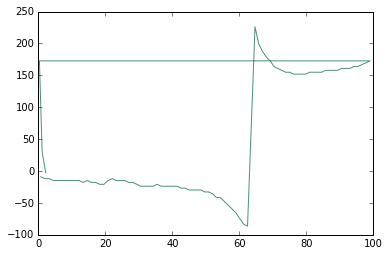

In [62]:
plt.figure(1)
color_pallette = ['#2274A5', '#B4656F', '#4E937A', '#F3D34A', '#A11692', '#F75C03', '#F1C40F', '#D90368', '#00CC66', '#540B0E', '#2274A5', '#B4656F', '#4E937A', '#F3D34A']
plt.plot(x,y,color=color_pallette[12])
plt.show()